# Clasificacion de datos mediante un modelo de red neuronal

El modelo es el siguiente
<p align="center">
<img src="imagenes/model_nn.png" style="width:600px;height:300px;">
</p>

In [351]:
#Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [352]:
#Funciones varias que se van a utilziar durante la ejecucion del modelo
def plot_decision_boundary(model, X, y):
    #Funcion aportada por @rvarun7777 en Github. Thanks a lot!
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s= 50, edgecolors= 'black' ,cmap=plt.cm.hot)
    
def cargar_datos():
    "Cargar conjunto de datos provistos por la libreria sklearn"
    # Numero de muestras 
    m = 200
    make_circles = sklearn.datasets.make_circles(n_samples=m, factor=.5, noise=.3)
    make_moons = sklearn.datasets.make_moons(n_samples=m, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples = m, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=1, n_samples=m, n_features=2, n_classes=2, shuffle=True, random_state=None)
    
    return make_circles, make_moons, blobs, gaussian_quantiles

In [353]:
make_circles, make_moons, blobs, gaussian_quantiles = cargar_datos()

conjuntos_datos = {"make_circles": make_circles,
                  "make_moons": make_moons,
                  "blobs": blobs,
                  "gaussian_quantiles": gaussian_quantiles}

seleccionar_conjunto_datos = "make_circles"

X, Y = conjuntos_datos[seleccionar_conjunto_datos]
X, Y = X.T, Y.reshape(1, Y.shape[0])

if seleccionar_conjunto_datos == "blobs":
    Y = Y % 2

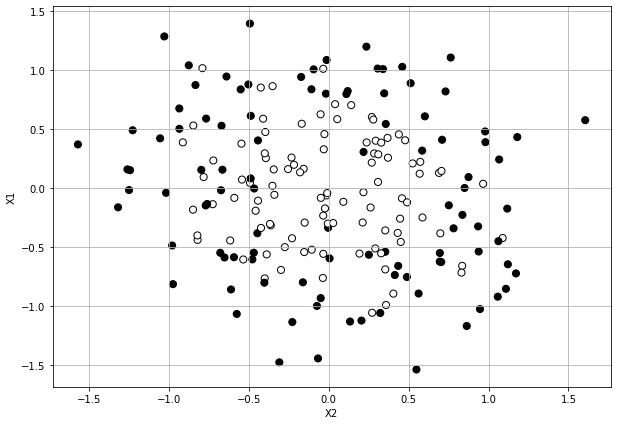

La forma de X es: (2, 200)
La forma de Y es: (1, 200)
Se disponen de m = 200 muestras de entrenamiento para la NN


In [354]:
#Visualizar los datos
plt.figure(figsize = (10,7))
plt.scatter(X[0, :], X[1, :], c = Y, s = 50, edgecolors = "black", cmap = plt.cm.hot)
plt.ylabel("X1")
plt.xlabel("X2")
plt.grid()
plt.show()

print("La forma de X es: " + str(X.shape))
print("La forma de Y es: " + str(Y.shape))
print("Se disponen de m = %d muestras de entrenamiento para la NN" % (X.shape[1]))

In [355]:
def tamanio_capas(X, Y):
    """
    Recibe el conjunto de datos.
    Devuelve el tamaño del input layer, y del output layer.
    """
    n_x = X.shape[0] # Tamaño de la capa de entrada.
    n_y = Y.shape[0] # Tamaño de la capa de salida.
    return (n_x, n_y)

In [356]:
def inicializar_parametros(n_x, n_h, n_y):
    """
    Recibe el tamaño del input layer, el numero de unidades en la hidden layer, y el tamaño de la output layer.
    Devuelve los parametros (tambien conocidos como Weigths) y los terminos bias para cada capa de la NN. 
    """
    np.random.seed(888)
    W1 = np.random.randn(n_h,n_x) * 0.1
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.1
    b2 = np.zeros((n_y,1))
  
    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

Para una muestra x:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$
$$y^{(i)}_{prediccion} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{en otro caso} \end{cases}$$

Como se trabaja de forma vectorizada, en X, Z, A, e incluso Y, cada columna representa a una entrada de la base de datos.

In [357]:
def sigmoid(z):
    """
    Funcion de activacion logistica. Se utiliza en la activacion de la ultima capa de la NN.
    Decide si un dato de entrada es de valor 0 o de valor 1.
    Recibe un vector o matriz, y le aplica la activacion logistica.
    """
    return 1 / (1 + np.exp(-z))

def forward_propagation(X, parametros):
    """
    Recibe los datos de entrada, y los parametros (inicializados o ya actualizados).
    Devuelve A2, basicamente la probabilidad de pertenecer a 1 o 0 para cada dato de entrada.
    Tambien guarda el resto de las actiavaciones.
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

El costo se lo define de la siguiente manera

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)}$$

In [358]:
def calcular_costo(A2, Y):
    """
    Recibe la activacion de la ultima capa de la NN, y los datos de salida (los verdaderos), de cada entrada.
    Devuelve el costo, basicamente que tan lejos esta el modelo de predecir valores correctos.
    """
    # Numero de muestras
    m = Y.shape[1] 

    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2),(1 - Y))
    costo = -(1/m) * np.sum(logprobs)  

    costo = float(np.squeeze(costo))
    
    return costo

In [359]:
def backward_propagation(parametros, cache, X, Y):
    """
    Se calcula el gradiente de los parametros.
    Recibe los parametros, los datos de entrada, y de salida.
    Devuelve el gradiente.
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parametros["W1"]
    W2 = parametros["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [360]:
def actualizar_parametros(parameters, grads, ritmo_aprendizaje):
    """
    Recibe los parametros, el gradiente y el learning rate.
    Devuelve los parametros actualizados.
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - ritmo_aprendizaje * dW1
    b1 = b1 - ritmo_aprendizaje * db1
    W2 = W2 - ritmo_aprendizaje * dW2
    b2 = b2 - ritmo_aprendizaje * db2
    
    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

In [361]:
def modelo_red_neuronal(X, Y, n_h, ritmo_aprendizaje, num_iteraciones = 10000, imprimir_costo = False):
    """
    El modelo de la NN basicamente ejecuta todas las funciones definidas anteriormente.
    Ejecuta el algoritmo gradient descent, en el que actualiza de manera iterativa los parametros.
    Devuelve los parametros en su valor (aproximadamente) optimo.
    """
    n_x = tamanio_capas(X, Y)[0]
    n_y = tamanio_capas(X, Y)[1]
    
    # Inicializar parametros
    parametros = inicializar_parametros(n_x, n_h, n_y)
    
    # Gradiente descendente
    for i in range(0, num_iteraciones):

        # Forward propagation.
        A2, cache = forward_propagation(X, parametros)
        # Se calcula el costo
        costo = calcular_costo(A2, Y) 
        # Backpropagation. Se calcula el gradiente.
        grads = backward_propagation(parametros, cache, X, Y)
        # Gradiente descencente: actualizacion de los parametros
        parametros = actualizar_parametros(parametros, grads, ritmo_aprendizaje)
       
        # Imprimir el costo cada 1000 iteraciones
        if imprimir_costo and i % 2000 == 0:
            print ("Costo tras la iteracion numero %i: %f" %(i, costo))

    return parametros

In [362]:
def predecir(parametros, X):
    """
    Recibe los parametros optimos, despues de ejecutar el modelo de NN.
    Devuelve lo que el modelo decide como si la entrada es de valor 0 o de valor 1.
    """
    A2, cache = forward_propagation(X, parametros)
    predicciones = np.round(A2)
    
    return predicciones

Con n_h, numero de iteraciones y el ritmo de aprendizaje como hiper-parametros, podemos ajustar el modelo para que entregue mejores resultados. A la hora de elegir el ritmo de aprendizaje, hay que tener en cuenta que dependiendo el valor de los gradientes, puede pasar lo siguiente
<p align="center">
<img src="imagenes/sgd.gif" style="width:400;height:400;"> <img src="imagenes/sgd_bad.gif" style="width:400;height:400;">
</p>

Costo tras la iteracion numero 0: 0.693115
Costo tras la iteracion numero 2000: 0.433934
Costo tras la iteracion numero 4000: 0.421567
Costo tras la iteracion numero 6000: 0.417147
Costo tras la iteracion numero 8000: 0.414959




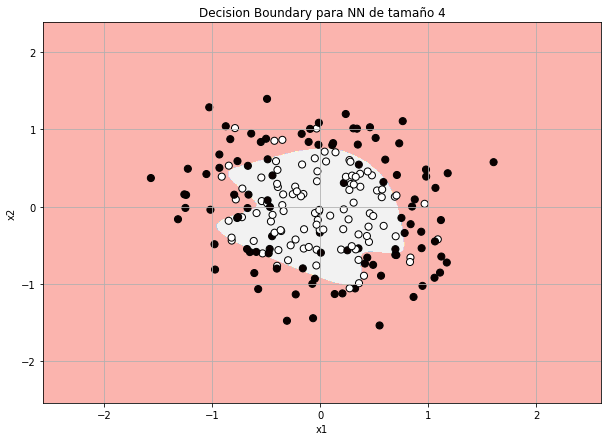

In [363]:
# Se puede jugar con el numero de unidades en la hidden layer, el learning rate y con el numero de iteraciones
n_h = 4
num_iteraciones = 10000
ritmo_aprendizaje = 1
parametros = modelo_red_neuronal(X, Y, n_h, ritmo_aprendizaje, num_iteraciones, imprimir_costo = True)

# Visualizamos el modelo.
print("\n")
plt.figure(figsize= (10,7))
plot_decision_boundary(lambda x: predecir(parametros, x.T), X, Y)
plt.title("Decision Boundary para NN de tamaño " + str(n_h))
plt.grid()
plt.show()

In [364]:
# Imprimir la precision del modelo
predictions = predecir(parametros, X)
print("Precisión: %d" % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + "%")

Precisión: 81%
